Q-Learning and Policy Iteration on the Frozen Lake Environment

In [1]:
pip install gymnasium

   ---------------------------------------- 0.0/953.9 kB ? eta -:--:--
   - ------------------------------------- 30.7/953.9 kB 660.6 kB/s eta 0:00:02
   ---------- ----------------------------- 256.0/953.9 kB 2.6 MB/s eta 0:00:01
   ----------------- ---------------------- 409.6/953.9 kB 3.2 MB/s eta 0:00:01
   ------------------------- -------------- 614.4/953.9 kB 3.9 MB/s eta 0:00:01
   --------------------------------- ------ 809.0/953.9 kB 3.9 MB/s eta 0:00:01
   ---------------------------------------  952.3/953.9 kB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 953.9/953.9 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


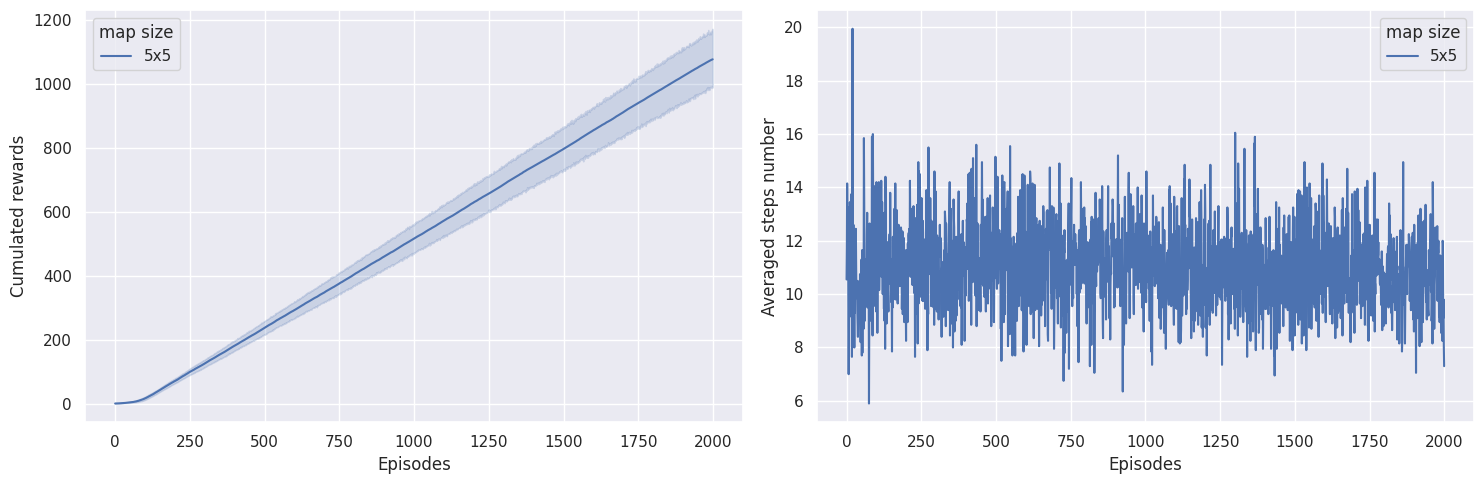

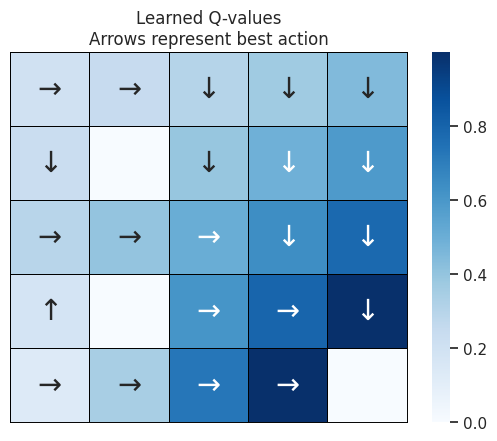

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:297: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_attr('P')` that will search the reminding wrappers.
  logger.warn(


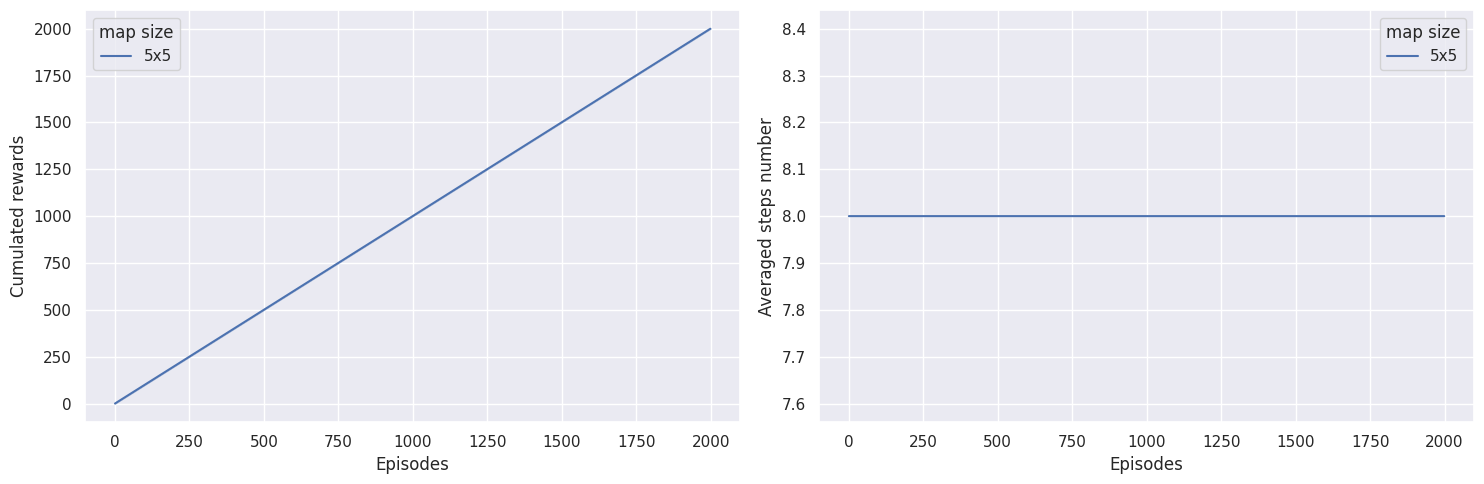

Hyperparameters: Learning Rate=0.1, Gamma=0.8, Epsilon=0.5
Q-Learning - Average Rewards: 0.53895
Q-Learning - Average Cumulated Rewards: 518.696925
Q-Learning - Average Steps: 11.03625
Policy Iteration - Average Rewards: 1.0
Policy Iteration - Average Cumulated Rewards: 1000.5
Policy Iteration - Average Steps: 8.0


In [42]:
from pathlib import Path
from typing import NamedTuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

# Set seaborn theme for better visualizations
sns.set_theme()

# Define parameters for the experiment using NamedTuple
class Params(NamedTuple):
    total_episodes: int
    learning_rate: float
    gamma: float
    epsilon: float
    map_size: int
    seed: int
    is_slippery: bool
    n_runs: int
    action_size: int
    state_size: int
    proba_frozen: float
    savefig_folder: Path

# Initialize parameters
params = Params(
    total_episodes=2000,
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    map_size=5,
    seed=123,
    is_slippery=False,
    n_runs=20,
    action_size=None,
    state_size=None,
    proba_frozen=0.9,
    savefig_folder=Path("C:/Users/Admin/Desktop/"),
)

# Create a random number generator
rng = np.random.default_rng(params.seed)

# Create a folder to save figures if it doesn't exist
params.savefig_folder.mkdir(parents=True, exist_ok=True)

# Create FrozenLake environment with specified parameters
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(
        size=params.map_size, p=params.proba_frozen, seed=params.seed
    ),
)

# Update parameters with environment-specific values
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n)

# Define Q-learning algorithm
class Qlearning:
    def __init__(self, learning_rate, gamma, state_size, action_size):
        # Initialize Q-learning algorithm.
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()

    def update(self, state, action, reward, new_state):
        # Update Q-values based on the Bellman equation.
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        # Reset Q-table to zeros.
        self.qtable = np.zeros((self.state_size, self.action_size))

# Define Epsilon-Greedy exploration strategy
class EpsilonGreedy:
    def __init__(self, epsilon):
        # Initialize Epsilon-Greedy exploration strategy.
        self.epsilon = epsilon

    def choose_action(self, action_space, state, qtable):
        # Choose an action using Epsilon-Greedy strategy.
        explor_exploit_tradeoff = rng.uniform(0, 1)
        if explor_exploit_tradeoff < self.epsilon:
            action = action_space.sample()  # Explore: Choose random action
        else:
            if np.all(qtable[state, :]) == qtable[state, 0]:
                action = action_space.sample()  # Explore: Choose random action
            else:
                action = np.argmax(qtable[state, :])  # Exploit: Choose action with highest Q-value
        return action

# Function to run Q-learning algorithm on the environment
def run_env_qlearning():
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    qtables = np.zeros((params.n_runs, params.state_size, params.action_size))
    all_states = []
    all_actions = []
    for run in range(params.n_runs):
        qlearner = Qlearning(
            learning_rate=params.learning_rate,
            gamma=params.gamma,
            state_size=params.state_size,
            action_size=params.action_size,
        )
        explorer = EpsilonGreedy(
            epsilon=params.epsilon,
        )
        for episode in tqdm(episodes, desc=f"Q-Learning Run {run}/{params.n_runs}", leave=False):
            state = env.reset(seed=params.seed)[0]
            step = 0
            done = False
            total_rewards = 0
            while not done:
                action = explorer.choose_action(action_space=env.action_space, state=state, qtable=qlearner.qtable)
                all_states.append(state)
                all_actions.append(action)
                new_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                qlearner.qtable[state, action] = qlearner.update(state, action, reward, new_state)
                total_rewards += reward
                step += 1
                state = new_state
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = qlearner.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

# Function to run Policy Iteration algorithm on the environment
def run_policy_iteration(params, env):
    rewards = np.zeros((params.total_episodes, params.n_runs))
    steps = np.zeros((params.total_episodes, params.n_runs))
    episodes = np.arange(params.total_episodes)
    all_states = []
    all_actions = []
    for run in range(params.n_runs):
        policy, _ = policy_iteration(params, env)
        for episode in tqdm(episodes, desc=f"Policy Iteration Run {run}/{params.n_runs}", leave=False):
            state = env.reset(seed=params.seed)[0]
            step = 0
            done = False
            total_rewards = 0
            while not done:
                action = policy[state]
                all_states.append(state)
                all_actions.append(action)
                new_state, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                total_rewards += reward
                step += 1
                state = new_state
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
    return rewards, steps, episodes, all_states, all_actions

# Function to post-process results
def postprocess(episodes, params, rewards, steps, map_size):
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=params.n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])
    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

# Function to plot Q-values map
def plot_q_values_map(qtable, env, map_size):
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    fig, ax = plt.subplots()
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax,
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0


Proximal Policy Optimization on an Atari Game Environment

In [33]:
pip install autorom

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym

class QLearning:
    def __init__(self, learning_rate, gamma, action_space_size, observation_space_size):
        # Initialize the Q-learning agent.
        self.action_space_size = action_space_size
        self.observation_space_size = observation_space_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.q_network = self.build_q_network()  # Initialize Q-network

    def build_q_network(self):
        # Build the Q-network.
        pass

    def update(self, state, action, reward, new_state):
        # Update the Q-values based on the observed transition.
        pass

    def choose_action(self, state, epsilon):
        # Choose an action using an epsilon-greedy policy.
        pass

def main():
    total_episodes = 1000
    learning_rate = 0.001
    gamma = 0.99
    epsilon = 0.1
    env = gym.make("SpaceInvaders-v0")
    action_space_size = env.action_space.n
    observation_space_size = env.observation_space.shape[0]
    q_learning = QLearning(learning_rate, gamma, action_space_size, observation_space_size)
    rewards = []
    for episode in range(total_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action = q_learning.choose_action(state, epsilon)
            new_state, reward, done, _ = env.step(action)
            q_learning.update(state, action, reward, new_state)
            episode_reward += reward
            state = new_state
        rewards.append(episode_reward)
        print(f"Episode {episode + 1}/{total_episodes}, Reward: {episode_reward}")
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Q-learning Rewards")
    plt.show()
    env.close()

if __name__ == "__main__":
    main()


In [ ]:
class PPOAgent:
    def __init__(self, learning_rate, gamma, action_space_size, observation_space_size):
        # Initialize the Proximal Policy Optimization (PPO) agent.
        self.action_space_size = action_space_size
        self.observation_space_size = observation_space_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.actor_critic = self.build_actor_critic()  # Initialize actor-critic model

    def build_actor_critic(self):
        # Build the actor-critic model.
        pass

    def update(self, trajectory):
        # Update the policy based on the collected trajectory.
        pass

    def choose_action(self, state):
        # Choose an action based on the current policy.
        pass

def main():
    total_episodes = 1000
    learning_rate = 0.001
    gamma = 0.99
    env = gym.make("SpaceInvaders-v0")
    action_space_size = env.action_space.n
    observation_space_size = env.observation_space.shape[0]
    ppo_agent = PPOAgent(learning_rate, gamma, action_space_size, observation_space_size)
    rewards = []
    for episode in range(total_episodes):
        state = env.reset()
        trajectory = [], [], [], [], []  # Initialize trajectory
        episode_reward = 0
        done = False
        while not done:
            action = ppo_agent.choose_action(state)
            new_state, reward, done, _ = env.step(action)
            # Collect trajectory
            trajectory[0].append(state)
            trajectory[1].append(action)
            trajectory[2].append(reward)
            trajectory[3].append(new_state)
            trajectory[4].append(done)
            episode_reward += reward
            state = new_state
        # Update policy using collected trajectory
        ppo_agent.update(trajectory)
        rewards.append(episode_reward)
        print(f"Episode {episode + 1}/{total_episodes}, Reward: {episode_reward}")
    # Plot rewards over episodes
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("PPO Rewards")
    plt.show()
    env.close()

if __name__ == "__main__":
    main()
